In [104]:
import scipy
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np

In [105]:
# Load dataset
data = fetch_california_housing()
X, y = data.data, data.target

In [106]:
# Example split based on geographic regions (latitude)
N = 6
latitudes = X[:, -2]  # Assuming latitude is the second last feature
bins = np.linspace(latitudes.min(), latitudes.max(), N+1)
group_indices = np.digitize(latitudes, bins) - 1

# Create splits
X_splits = [X[group_indices == i] for i in range(N)]
y_splits = [y[group_indices == i] for i in range(N)]
X_splits_train, X_splits_test = [data[:-100] for data in X_splits], [data[-100:] for data in X_splits]
y_splits_train, y_splits_test = [data[:-100] for data in y_splits], [data[-100:] for data in y_splits]
print(list(map(len, X_splits_train)))
print(list(map(len, X_splits_test)))

[8348, 3213, 1435, 6083, 724, 235]
[100, 100, 100, 100, 100, 100]


In [107]:
def run_lin_reg(X_tr, y_tr):
    Xinv = np.linalg.pinv(X_tr)
    c = Xinv.dot(y_tr)
    tr = np.trace(Xinv.dot(Xinv.T))
    return c, tr

(8348, 8) (8348,)


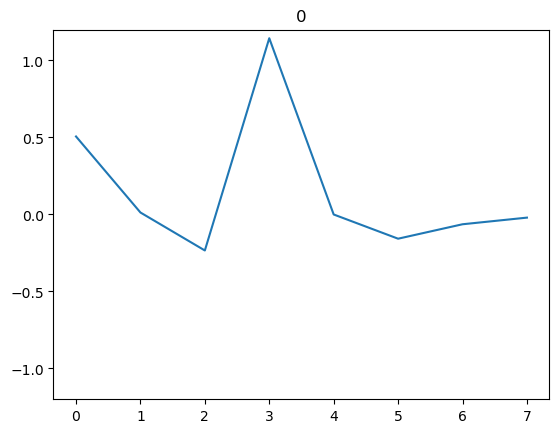


(3213, 8) (3213,)


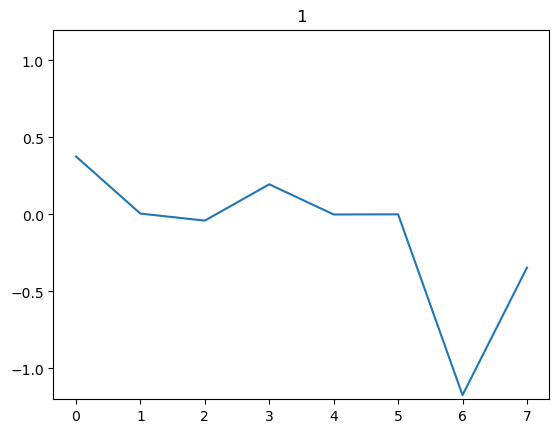


(1435, 8) (1435,)


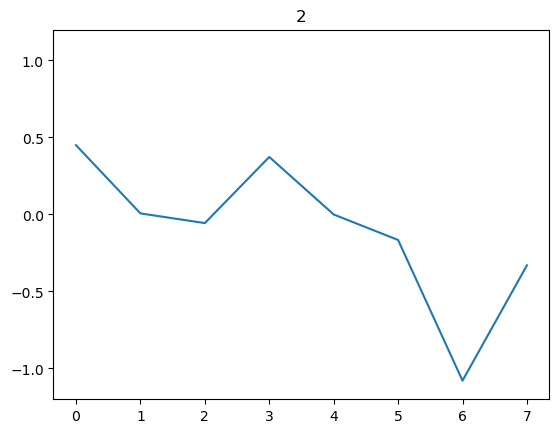


(6083, 8) (6083,)


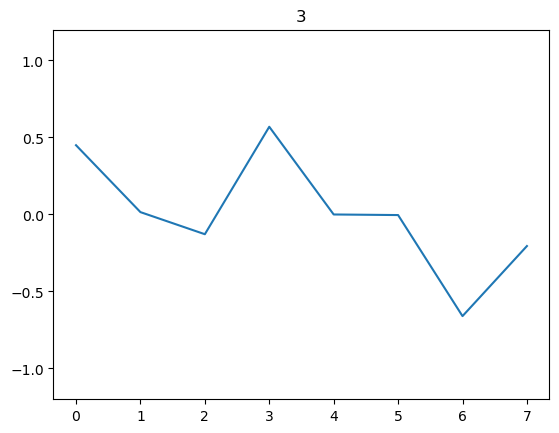


(724, 8) (724,)


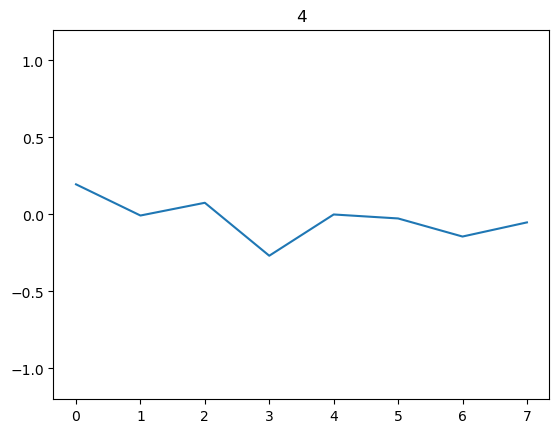


(235, 8) (235,)


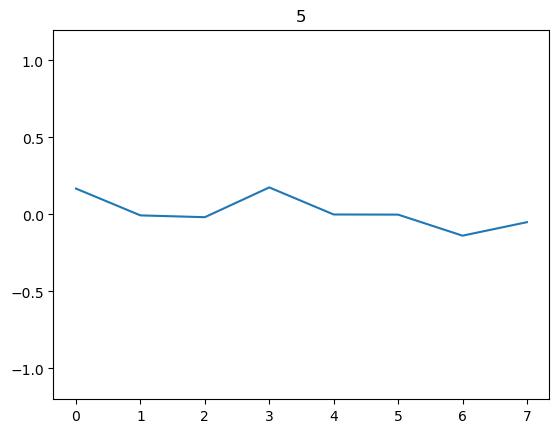


(6, 8)


In [108]:
var_squared = []
betas = []

for i in range(N):
    X_small, y_small = X_splits_train[i], y_splits_train[i]
    print(X_small.shape, y_small.shape)
    
    c, tr = run_lin_reg(X_small, y_small)
    
    betas.append(c)
    
    plt.plot(c)
    plt.gca().set_ylim([-1.2,1.2])
    plt.title(f"{i}")
    plt.show()
    
    m = X_small.shape[0]
    r = sum((y_small - X_small.dot(c))**2)
    var_squared.append(r/m*tr)
    print()

betas = np.array(betas)
print(betas.shape)

In [109]:
def get_weights(E_bs_hats, bs_star, var_squared):
    C = E_bs_hats.dot(E_bs_hats.T)
    K = bs_star.dot(E_bs_hats.T)
    return scipy.linalg.solve(C + np.diag(var_squared), K.T, assume_a='sym').T

In [110]:
num_iter = 2
n = betas.shape[0]
d = betas.shape[1]

# OLS. iterative fusion, update W and bs_hat
new_est = betas
W_hats = []
for ii in range(num_iter):
    W_hat = get_weights(new_est, new_est, var_squared)
    new_est = W_hat.dot(new_est)
    W_hats.append(W_hat)

In [111]:
new_est = betas
for W in W_hats:
    new_est = W.dot(new_est)

auc_results = np.zeros((2, N))

for ii, iii in enumerate(range(N)):
    print(iii, N)
    print( )
    auc_results[0, ii] = ((y_splits_test[ii] - X_splits_test[ii].dot(betas[ii, :]).shape) ** 2).mean()
    auc_results[1, ii] = ((y_splits_test[ii] - X_splits_test[ii].dot(new_est[ii, :]).shape) ** 2).mean()
    
    print('before fusion:', np.round(auc_results[0, ii], 4))
    print('after fusion:', np.round(auc_results[1, ii], 4))
    print( )

0 6

before fusion: 9624.3071
after fusion: 9624.3071

1 6

before fusion: 9474.8153
after fusion: 9474.8153

2 6

before fusion: 9865.4617
after fusion: 9865.4617

3 6

before fusion: 9729.0465
after fusion: 9729.0465

4 6

before fusion: 9850.2129
after fusion: 9850.2129

5 6

before fusion: 9847.1667
after fusion: 9847.1667



In [113]:
betas

array([[ 5.06471861e-01,  1.28452608e-02, -2.33787942e-01,
         1.14449884e+00,  4.80824314e-06, -1.57269441e-01,
        -6.35502144e-02, -2.04426898e-02],
       [ 3.76506891e-01,  5.71442017e-03, -3.97259043e-02,
         1.96073501e-01, -3.97804546e-05,  8.91453114e-04,
        -1.17310644e+00, -3.45647303e-01],
       [ 4.49949106e-01,  6.96432430e-03, -5.58673882e-02,
         3.73469267e-01,  3.24729154e-05, -1.65564445e-01,
        -1.07903506e+00, -3.30232811e-01],
       [ 4.49742540e-01,  1.53077215e-02, -1.28187724e-01,
         5.69514434e-01,  2.83437997e-05, -3.78006345e-03,
        -6.59972968e-01, -2.04971236e-01],
       [ 1.95803731e-01, -6.77484133e-03,  7.59853342e-02,
        -2.67864625e-01,  2.98117015e-05, -2.57991636e-02,
        -1.43270107e-01, -5.14421842e-02],
       [ 1.68054169e-01, -5.91204031e-03, -1.75779667e-02,
         1.75631834e-01, -1.93671656e-05, -8.89466571e-04,
        -1.37620440e-01, -5.00173943e-02]])

In [114]:
new_est

array([[ 5.02643873e-01,  1.43702802e-02, -2.36012690e-01,
         1.14078178e+00,  1.41452033e-05, -1.41474987e-01,
        -6.62997139e-02, -2.33850875e-02],
       [ 3.86170630e-01,  9.33093096e-03, -4.22885283e-02,
         1.94421159e-01, -2.39640805e-06,  5.83136662e-03,
        -1.16110544e+00, -3.49280367e-01],
       [ 4.74189830e-01,  8.17025682e-03, -6.88423516e-02,
         3.72490559e-01,  2.73069241e-06, -7.10968239e-02,
        -1.06606391e+00, -3.21573472e-01],
       [ 4.41116305e-01,  1.16429830e-02, -1.20629581e-01,
         5.69260554e-01,  9.01648506e-06, -3.74413467e-02,
        -6.61123194e-01, -2.01771920e-01],
       [ 1.75457551e-01, -6.30711852e-03,  7.26253672e-02,
        -2.58982673e-01,  2.79429742e-05, -2.07925418e-02,
        -1.48225889e-01, -5.26582459e-02],
       [ 1.60583675e-01,  2.63919275e-03, -3.35946109e-02,
         1.72234408e-01,  8.61590543e-06, -1.94924626e-02,
        -1.41380562e-01, -4.50484240e-02]])